In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from typing import Optional


from sklearn.model_selection import GridSearchCV, cross_val_score
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
import networkx as nx

warnings.filterwarnings('ignore')


# Helping Functions

In [2]:
def calculate_rule_support(df: pd.DataFrame, body_and_head_values:dict[str, str]) -> float:
    """Calculates the support of the rule 

    Args:
        df (pd.DataFrame): dataframe to calculate the support
        body_and_head_values (dict[str, str]): dictionary containing the column names and values of the rule

    Returns:
        float: support of the rule
    """
    no_of_rows = df.shape[0]
    support = 0
    for i in range(no_of_rows):
        is_rule_satisfied = True
        for column, value in body_and_head_values.items():
            if df[column][i] != value:
                is_rule_satisfied = False
                break
        if is_rule_satisfied:
            support += 1
    if no_of_rows == 0:
        return 0
    return support/no_of_rows

def calculate_rule_confidence(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> float:
    """calculates the confidence of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the confidence
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        float: confidence of the rule
    """
    no_of_rows = df.shape[0]
    body_support = calculate_rule_support(df, body_values)
    Whead_support = calculate_rule_support(df, head_values)
    body_head_support = calculate_rule_support(df, {**body_values, **head_values})
    if body_support == 0:
        return 0
    return body_head_support/body_support

def calculate_rule_lift(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> float:
    """calculates the lift of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the lift
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        float: lift of the rule
    """
    body_support = calculate_rule_support(df, body_values)
    head_support = calculate_rule_support(df, head_values)
    body_head_support = calculate_rule_support(df, {**body_values, **head_values})
    if body_support == 0 or head_support == 0:
        return 0
    return body_head_support/(body_support*head_support)

def rule_info(df: pd.DataFrame, body_values : dict[str, str], head_values : dict[str, str]) -> dict[str, float]:
    """calculates the support, confidence and lift of the rule

    Args:
        df (pd.DataFrame): dataframe to calculate the rule info
        body_values (dict[str, str]): dictionary containing the column names and values of the body of the rule
        head_values (dict[str, str]): dictionary containing the column names and values of the head of the rule

    Returns:
        dict[str, float]: dictionary containing the support, confidence and lift of the rule
    """
    return {
        "support": calculate_rule_support(df, {**body_values, **head_values}),
        "confidence": calculate_rule_confidence(df, body_values, head_values),
        "lift": calculate_rule_lift(df, body_values, head_values)
    }
    
def create_encoder(df : pd.DataFrame, categorical_cols : list[str]) -> tuple[OneHotEncoder, list[str], list[dict[str, str]]]:
    """Creates an encoder for the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to create the encoder
        categorical_cols (list[str]): list of categorical columns

    Returns:
        tuple[OneHotEncoder, list[str], list[dict[str, str]]]: OneHotEncoder for categorical columns
    """
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(df[categorical_cols])
    encoded_feature_cols = encoder.get_feature_names_out(categorical_cols)
    feature_groups = []
    
    for col_1 in encoded_feature_cols:
        col_1_cat = col_1.rsplit('_', 1)[0]
        for cat in categorical_cols:
            if col_1_cat == cat and cat not in [group['variable'] for group in feature_groups]:
                feature_groups.append({'variable': cat, 'columns': [col_2 for col_2 in encoded_feature_cols if col_2.rsplit('_', 1)[0] == cat]})
                    
    return encoder, encoded_feature_cols, feature_groups
    

def one_hot_encode_df(df: pd.DataFrame, categorical_cols : list[str], encoder = OneHotEncoder) -> pd.DataFrame:
    """One hot encodes the categorical columns of the dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        categorical_cols (list[str]): columns to encode
        encoder (_type_, optional): en. Defaults to OneHotEncoder.

    Returns:
        pd.DataFrame: encoded dataframe
    """
    encoded =  encoder.fit_transform(df[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns = encoder.get_feature_names_out(categorical_cols))
    df_oh = df.drop(categorical_cols, axis=1).join(encoded_df)
    return df_oh

def make_readable_encoded_column_names(df : pd.DataFrame, encoded_feature_cols : list[str], category_map) -> pd.DataFrame:
        """Renames the columns in a readable way based on the category_map"""
        readable_colnames = [] 
        for col in encoded_feature_cols:
            cat_name, cat_value = col.rsplit('_', 1)
            cat_value = int(cat_value)  
            if cat_name in category_map:
                if cat_value in category_map[cat_name]:
                    readable_colnames.append(f"{cat_name}_{category_map[cat_name][cat_value]}")
                else:
                    readable_colnames.append(col)
            else:
                readable_colnames.append(col)
        encoded_df = df[encoded_feature_cols]
        readable_encoded_df = pd.DataFrame(encoded_df.values, columns=readable_colnames)
        readable_df = df.drop(encoded_feature_cols, axis=1).join(readable_encoded_df)
        return readable_df

def fill_with_mode(df : pd.DataFrame, column : str) -> pd.DataFrame: 
    """Fills the missing values of the column with the mode of the column

    Args:
        df (pd.DataFrame): dataframe to fill
        column (str): column to fill

    Returns:
        pd.DataFrame: dataframe with filled column
    """
    mode = df[column].mode()[0]
    df[column] = df[column].fillna(mode)
    return df


## Read data from csv file

In [3]:
HEART_DATA = pd.read_csv('data/heart.csv')
print(f"Heart data shape: {HEART_DATA.shape}")

Heart data shape: (303, 14)


In [4]:
HEART_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


## Data descriptions: 

1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. ca - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

In [5]:
CATEGORICAL_COLS = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall'] 
NUMERICAL_COLS = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
TARGET_COLUMN = 'output'

In [6]:
#Making a dictonary to be able to map the column-names of the encoded dataframe to more readable descriptive names
CATEGORY_MAP = {
    'sex': {0: 'female', 1: 'male'},
    'fbs': {0: '<=120mg/dl', 1: '>120mg/dl'},
    'restecg': {0: 'hypertrophy', 1: 'normal', 2: 'having_ST-T_wave_abnormality'},
    'cp': {0: 'asymptomatic', 1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal_pain'},
    'exng': {0: 'No', 1: 'Yes'},
    'slp': {0: 'downsloping', 1: 'flat', 2: 'upsloping'},
    'caa': {0: '0', 1: '1', 2: '2', 3: '3'},
    'thall': {1: 'fixed_defect', 2: 'normal', 3: 'reversible_defect'},
}

In [7]:
def make_readable_df(df : pd.DataFrame, category_map) -> pd.DataFrame:
    #Change the values in the dataframe to more readable values
    for column in df.columns:
        if column in category_map:
            df[column] = df[column].map(category_map[column])
    return df 

HEART_DATA_READABLE = make_readable_df(HEART_DATA.copy(), CATEGORY_MAP)
HEART_DATA_READABLE

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,male,non_anginal_pain,145,233,>120mg/dl,hypertrophy,150,No,2.3,downsloping,0,fixed_defect,1
1,37,male,atypical_angina,130,250,<=120mg/dl,normal,187,No,3.5,downsloping,0,normal,1
2,41,female,typical_angina,130,204,<=120mg/dl,hypertrophy,172,No,1.4,upsloping,0,normal,1
3,56,male,typical_angina,120,236,<=120mg/dl,normal,178,No,0.8,upsloping,0,normal,1
4,57,female,asymptomatic,120,354,<=120mg/dl,normal,163,Yes,0.6,upsloping,0,normal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,female,asymptomatic,140,241,<=120mg/dl,normal,123,Yes,0.2,flat,0,reversible_defect,0
299,45,male,non_anginal_pain,110,264,<=120mg/dl,normal,132,No,1.2,flat,0,reversible_defect,0
300,68,male,asymptomatic,144,193,>120mg/dl,normal,141,No,3.4,flat,2,reversible_defect,0
301,57,male,asymptomatic,130,131,<=120mg/dl,normal,115,Yes,1.2,flat,1,reversible_defect,0


# 1. Datacleaning

## Inspection of missing values

In [8]:
#Check for missing values 
df = HEART_DATA.copy()
missing_data_info = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1, keys=['Total Missing Values', 'Percentage'])
missing_data_info

,Total Missing Values,Percentage
age,0,0.0
sex,0,0.0
cp,0,0.0
trtbps,0,0.0
chol,0,0.0
fbs,0,0.0
restecg,0,0.0
thalachh,0,0.0
exng,0,0.0
oldpeak,0,0.0


In [9]:
#Check for duplicates
duplicates = HEART_DATA.duplicated().sum()
duplicates

1

In [10]:
#drop duplicates
df = df.drop_duplicates(keep='first')

In [11]:
#check unique values for categorical columns
HEART_DATA_CAT = HEART_DATA.copy()[CATEGORICAL_COLS] 
unique_values = HEART_DATA_CAT.nunique()
unique_values_df = pd.DataFrame({
    'Column': unique_values.index,
    'Unique Values Count': unique_values.values,
    'Unique Values': [HEART_DATA_CAT[col].unique() for col in CATEGORICAL_COLS]
})
unique_values_df

,Column,Unique Values Count,Unique Values
0,sex,2,"[1, 0]"
1,cp,4,"[3, 2, 1, 0]"
2,fbs,2,"[1, 0]"
3,restecg,3,"[0, 1, 2]"
4,exng,2,"[0, 1]"
5,slp,3,"[0, 2, 1]"
6,caa,5,"[0, 2, 1, 3, 4]"
7,thall,4,"[1, 2, 3, 0]"


- From the dataframe we can observe that "caa" contains 5 unique values, even though there is only 4 allowed values. Caa are supposed to only have values between 0-3 and any row with caa = 4 can be treated as "null". Will change all 4's to NULL and then We will need to either delete those rows, or use some method to fill the null values. 
- We can also observe that there is 4 values for "thall", but there is supposed to only be 3 (between 1-3). 0 is NULL so we will change them to be NULL and then use a method to fill the NULL values. 

In [12]:
HEART_DATA['caa'] = HEART_DATA['caa'].replace(4, pd.NA)  # Replace 4 in 'caa' with NaN
HEART_DATA['thall'] = HEART_DATA['thall'].replace(0, pd.NA)  # Replace 0 in 'thall' with NaN
HEART_DATA.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         5
thall       2
output      0
dtype: int64

## Imputation of missing values

Decide to fill the missing values with the mode of the features as there is a low number of missing 

In [13]:
HEART_DATA = fill_with_mode(HEART_DATA, 'thall')
HEART_DATA = fill_with_mode(HEART_DATA, 'caa')

# Data visualization and analysis

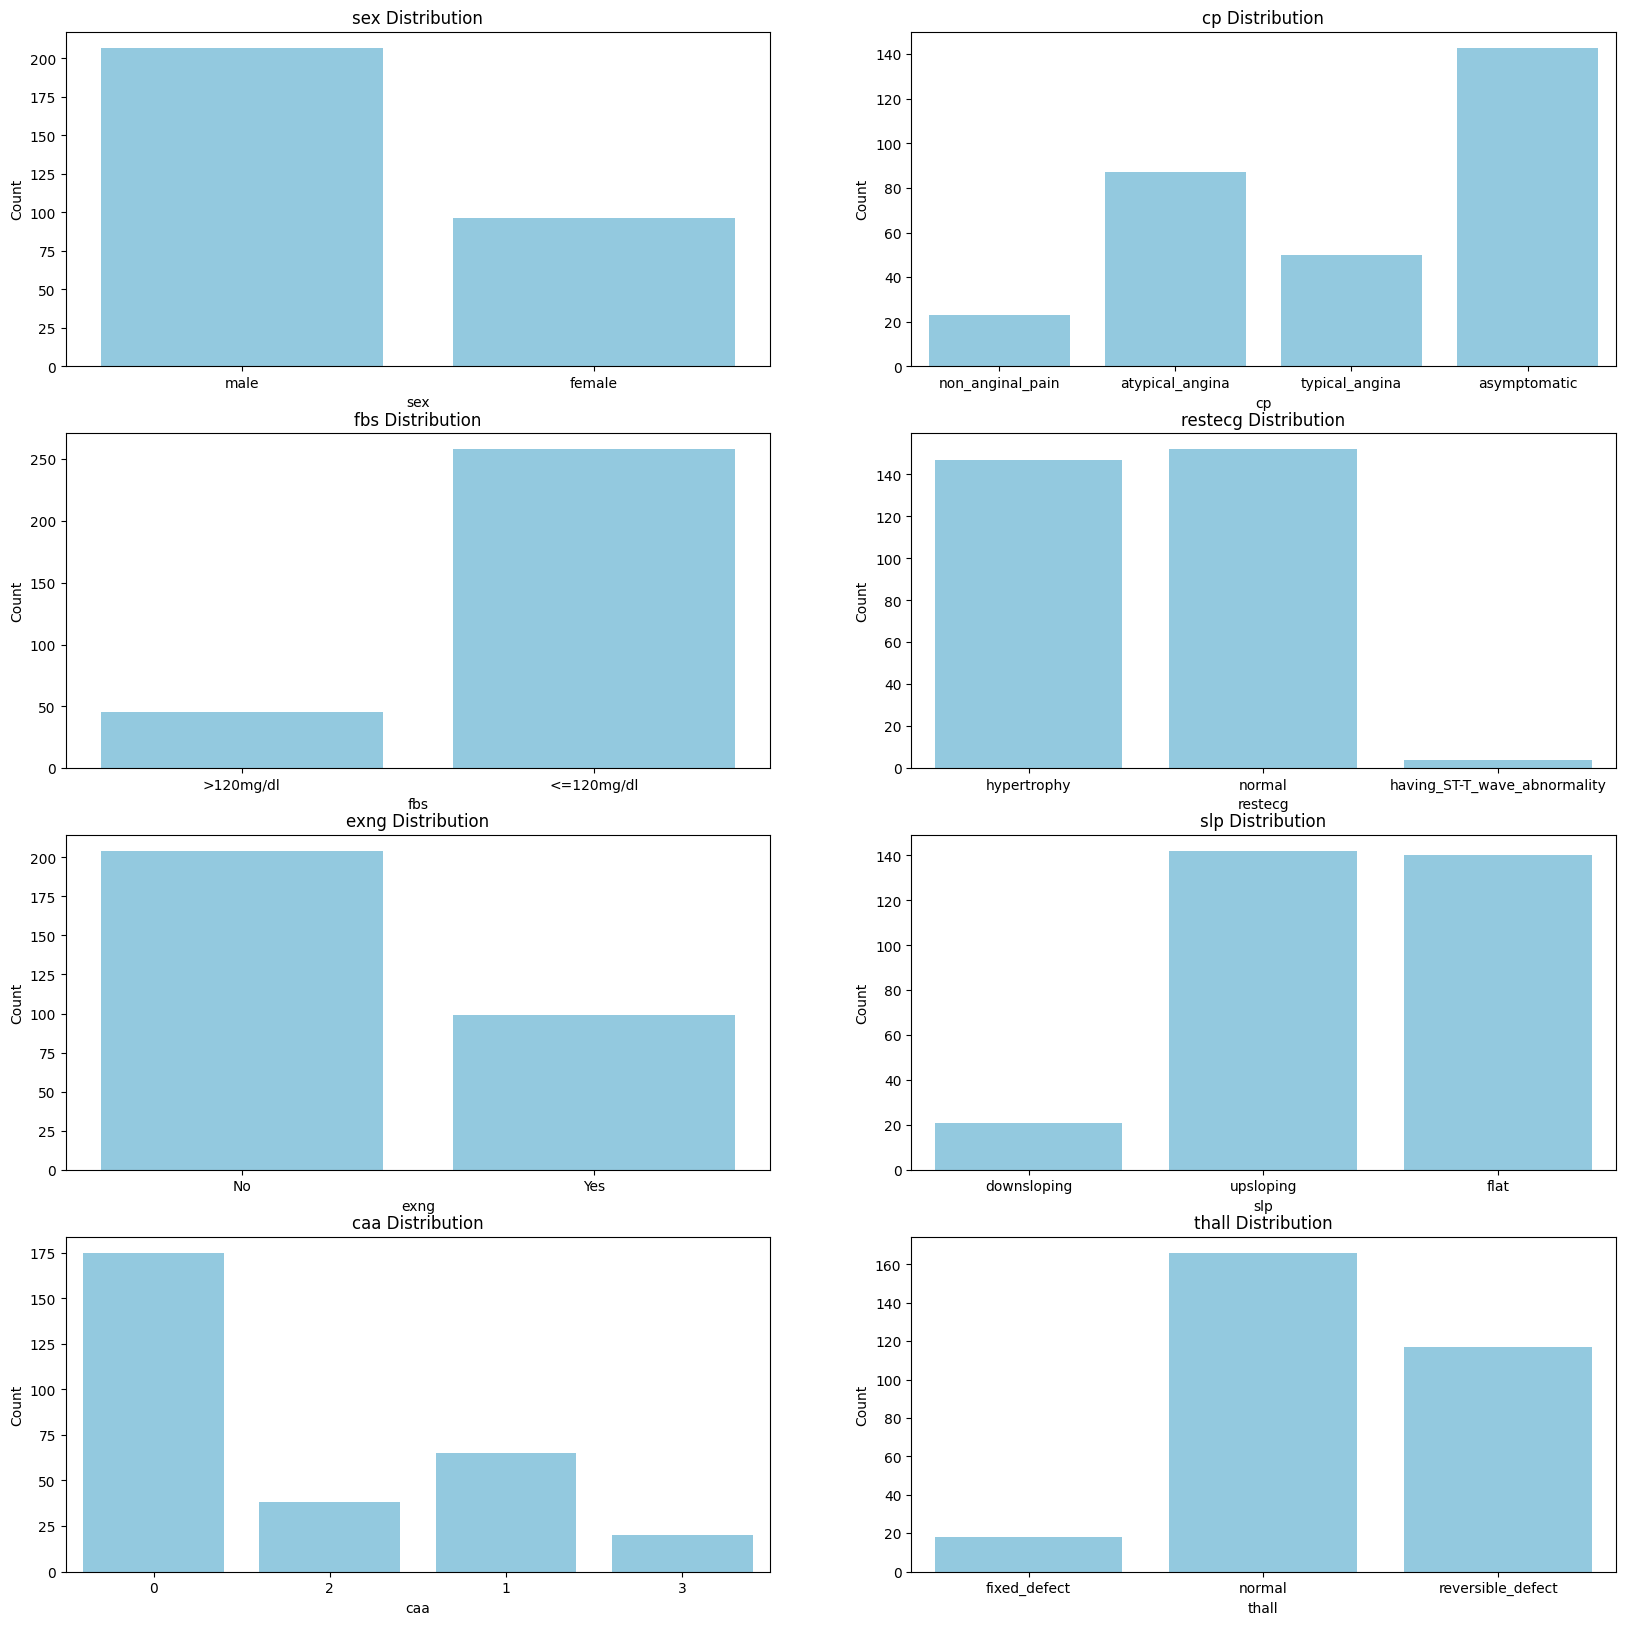

In [14]:
fix, axes = plt.subplots(4, 2, figsize=(20, 20))
for col in CATEGORICAL_COLS:
    sns.countplot(
        x=col,
        data=HEART_DATA_READABLE,
        ax=axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2],
        color='skyblue'
    )
    axes[CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2].set_title(
        f"{col} Distribution"
    )
    axes[
        CATEGORICAL_COLS.index(col) // 2, CATEGORICAL_COLS.index(col) % 2
    ].set_ylabel("Count")
plt.show()

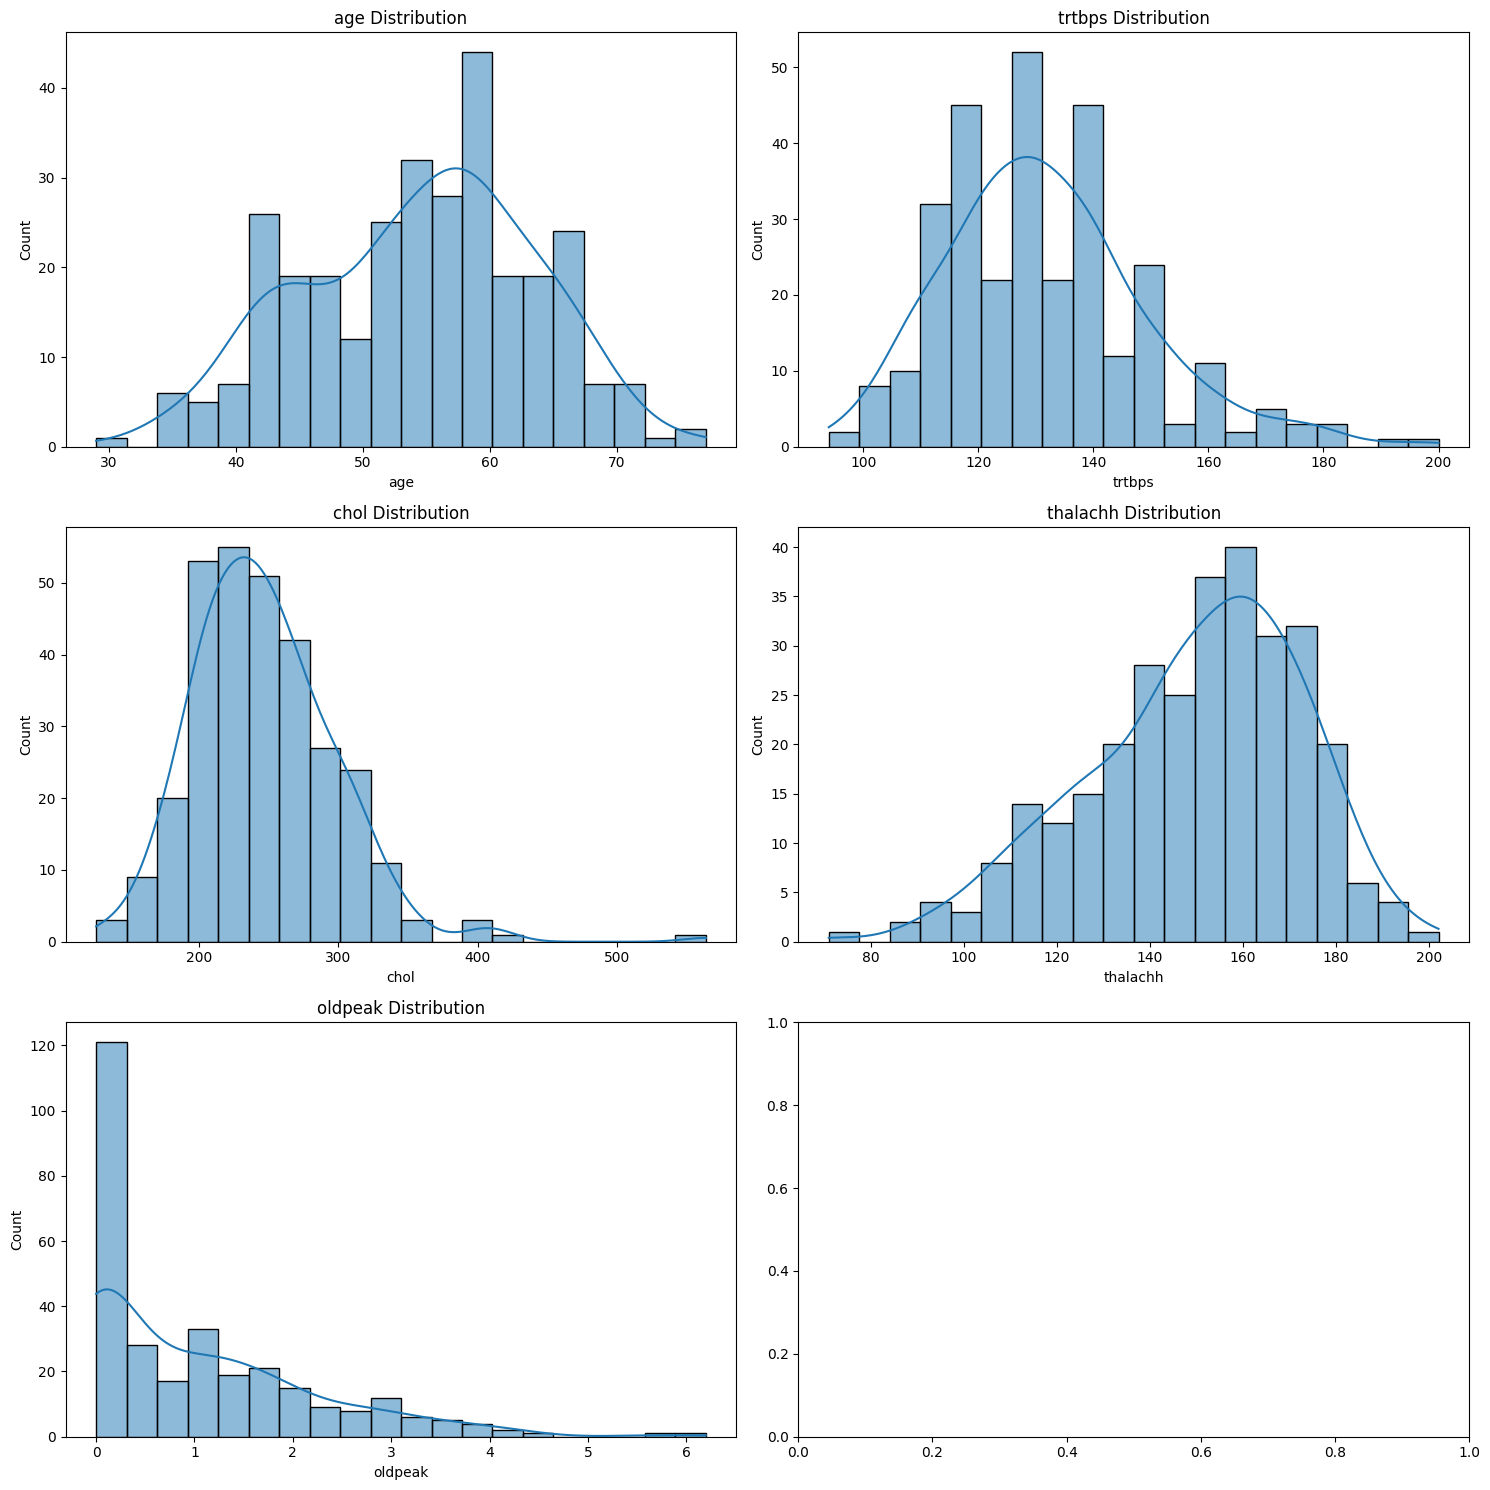

In [15]:
fig,axes = plt.subplots(3,2, figsize = (15,15))
r, c = 0,0
for column in NUMERICAL_COLS: 
    sns.histplot(HEART_DATA[column], kde=True, ax=axes[r,c], bins = 20)
    axes[r,c].set_title(f'{column} Distribution')
    c+=1
    if c == 2:
        c = 0
        r += 1

plt.tight_layout()
plt.show()

### Correlation matrix numerical features

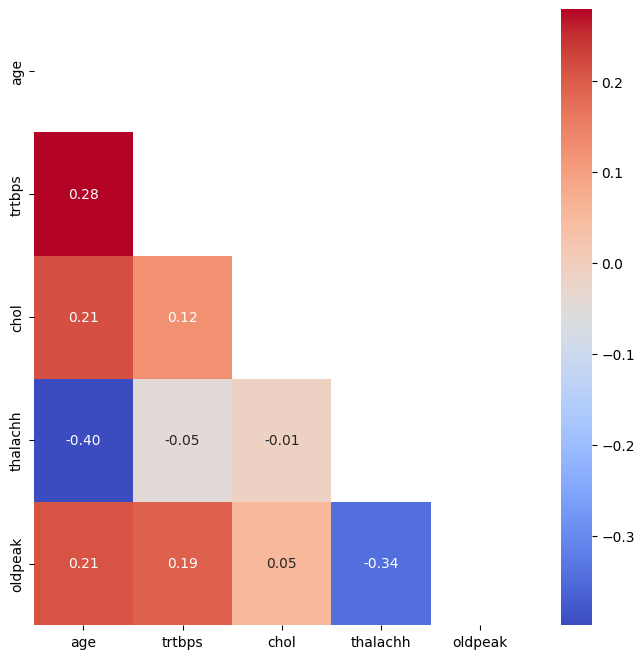

In [16]:
#Correlation matrix for numerical features
def plot_heat_num(df : pd.DataFrame):
    df_corr = df.corr()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    plt.figure(figsize=(8,8))
    sns.heatmap(df_corr, mask = mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

scaler = StandardScaler()
NUM_SCALED = scaler.fit_transform(HEART_DATA[NUMERICAL_COLS])
NUMERICAL_DF_SCALED = pd.DataFrame(NUM_SCALED, columns=NUMERICAL_COLS)
plot_heat_num(NUMERICAL_DF_SCALED)

### Correlation matrix all features (encoded categorical)

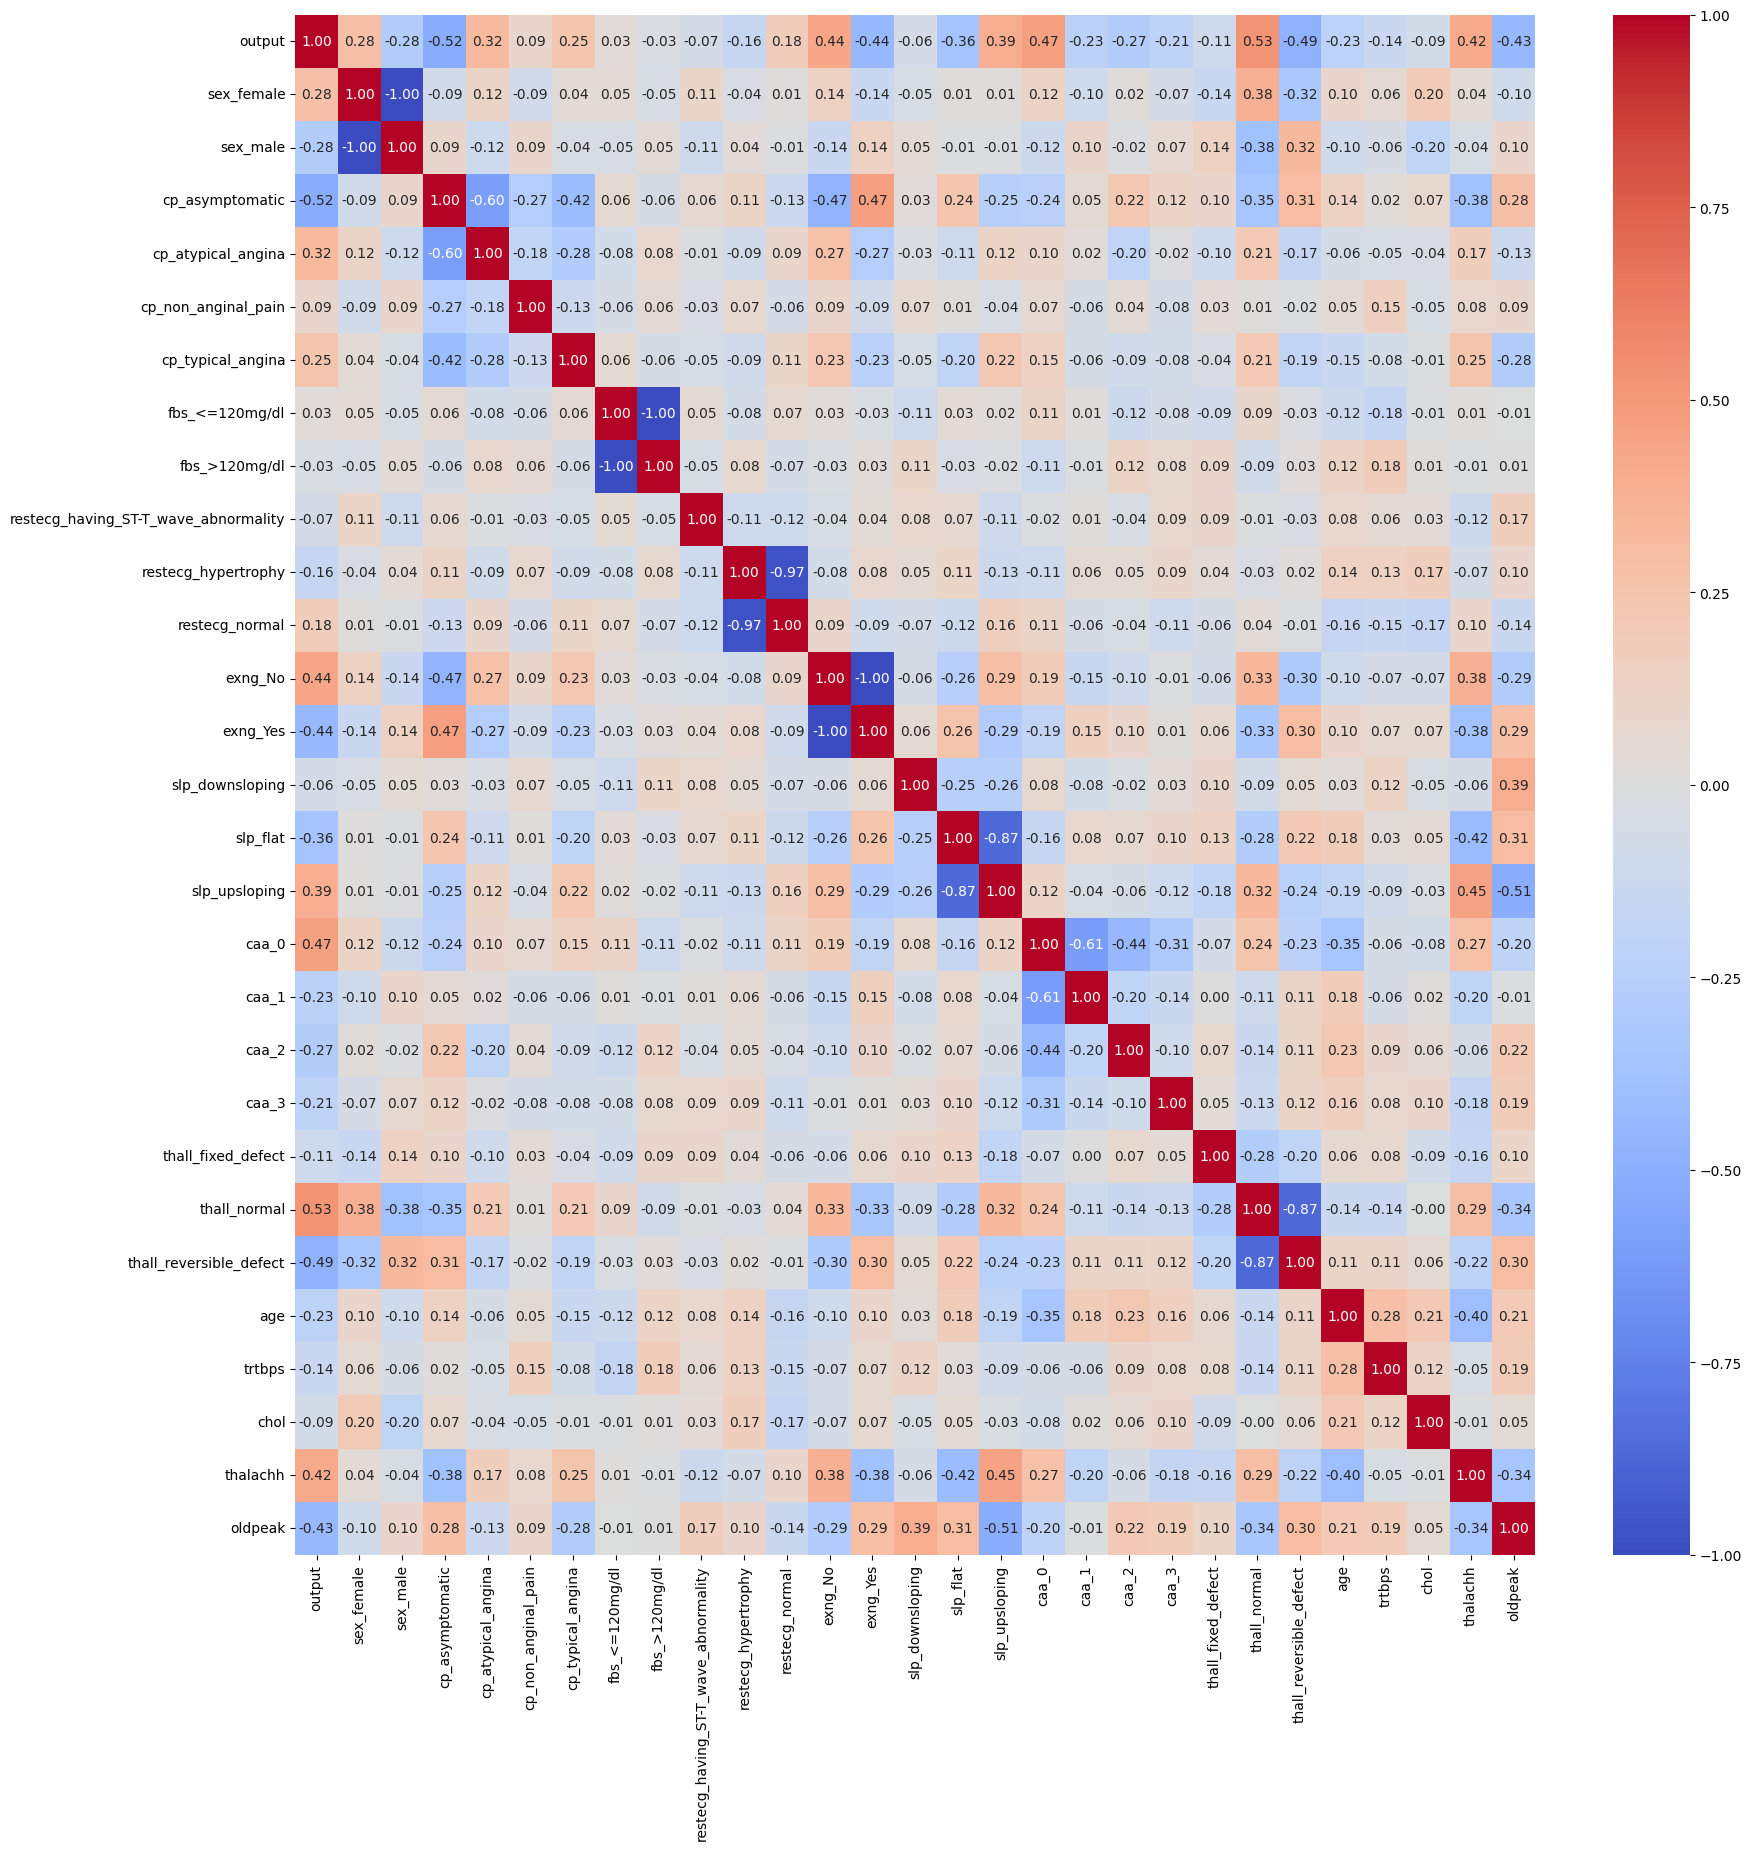

In [17]:
#Encode the categorical columns
DUMMY_DF = pd.get_dummies(HEART_DATA_READABLE, columns=CATEGORICAL_COLS, drop_first=False)
DUMMY_DF = DUMMY_DF.drop(NUMERICAL_COLS, axis=1)
MATRIX_DF = pd.concat([DUMMY_DF, NUMERICAL_DF_SCALED], axis=1)

def plot_heat_all(df : pd.DataFrame):
    df_corr = df.corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()
plot_heat_all(MATRIX_DF)

### Correlation with target

In [18]:
CORR_TARGET = MATRIX_DF.corr()[TARGET_COLUMN].sort_values(ascending=False)
CORR_TARGET.drop(TARGET_COLUMN, inplace=True)
CORR_TARGET_TABLE = CORR_TARGET.to_frame().reset_index()
CORR_TARGET_TABLE.columns = ['Feature', 'Correlation with Target']
CORR_TARGET_TABLE.style.background_gradient(cmap='coolwarm')

,Feature,Correlation with Target
0,thall_normal,0.527334
1,caa_0,0.465590
2,exng_No,0.436757
3,thalachh,0.421741
4,slp_upsloping,0.394066
5,cp_atypical_angina,0.316742
6,sex_female,0.280937
7,cp_typical_angina,0.245879
8,restecg_normal,0.175322
9,cp_non_anginal_pain,0.086957


# Association rule mining 

Before performing the ARM, I want to use clustering to add another column to the dataset with categories for age

In [19]:
HEART_DATA_ARM = HEART_DATA.copy()
ages = HEART_DATA_ARM[['age']]

#Scale the age for better clustering
scaler = StandardScaler()
ages_scaled = scaler.fit_transform(ages)

#Using KMeans to cluster the ages
kmeans = KMeans(n_clusters=4, random_state=42)
HEART_DATA_ARM['age_cluster'] = kmeans.fit_predict(ages_scaled)

#Want to see the age ranges for each cluster
HEART_DATA_ARM['age_cluster'] = HEART_DATA_ARM['age_cluster'].astype(int)  
age_cluster_ranges = HEART_DATA_ARM.groupby('age_cluster')['age'].agg(['min', 'max']).reset_index()
age_cluster_ranges

,age_cluster,min,max
0,0,29,46
1,1,56,63
2,2,47,55
3,3,64,77


Will then add a mapping from the age_clusters to a more descriptive name of each categoru to the category map. 

In [20]:
#do it more generic by ussing age_cluster_ranges
CATEGORY_MAP['age_cluster'] = {i: f"{age_cluster_ranges['min'][i]}_to_{age_cluster_ranges['max'][i]}" for i in range(4)}

### Find frequent itemsets

In [21]:
COLS_TO_ENCODE = CATEGORICAL_COLS + ['age_cluster', 'output']
ENCODER, ENCODED_FEATURE_COLS, FEATURE_GROUPS = create_encoder(HEART_DATA_ARM, COLS_TO_ENCODE)
HEART_DATA_ONE_HOT = one_hot_encode_df(HEART_DATA_ARM, COLS_TO_ENCODE, ENCODER)
HEART_DATA_ONE_HOT_READABLE = make_readable_encoded_column_names(HEART_DATA_ONE_HOT, ENCODED_FEATURE_COLS.tolist(), CATEGORY_MAP)

In [22]:
HEART_DATA_ONE_HOT_READABLE

,age,trtbps,chol,thalachh,oldpeak,sex_female,sex_male,cp_asymptomatic,cp_typical_angina,cp_atypical_angina,...,caa_3,thall_fixed_defect,thall_normal,thall_reversible_defect,age_cluster_29_to_46,age_cluster_56_to_63,age_cluster_47_to_55,age_cluster_64_to_77,output_0,output_1
0,63,145,233,150,2.3,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,37,130,250,187,3.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,41,130,204,172,1.4,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,56,120,236,178,0.8,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,57,120,354,163,0.6,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,140,241,123,0.2,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
299,45,110,264,132,1.2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
300,68,144,193,141,3.4,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
301,57,130,131,115,1.2,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
#Finding frequent itemsets for the categorical columns
CATEGORICAL_DATA_ONE_HOT = HEART_DATA_ONE_HOT_READABLE[HEART_DATA_ONE_HOT_READABLE.columns.difference(NUMERICAL_COLS + [TARGET_COLUMN])]
CATEGORICAL_DATA_ONE_HOT
FREQ_ITEMSETS = apriori(CATEGORICAL_DATA_ONE_HOT, min_support= 0.3, use_colnames=True)
ASSOCIATION_RULES = association_rules(FREQ_ITEMSETS, metric="confidence", min_threshold=0.4, num_itemsets=len(FREQ_ITEMSETS))
ASSOCIATION_RULES.to_csv('data/association_rules.csv')
ASSOCIATION_RULES[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(exng_No),(caa_0),0.445545,0.661765,1.113971
1,(caa_0),(exng_No),0.445545,0.750000,1.113971
2,(fbs_<=120mg/dl),(caa_0),0.524752,0.616279,1.037403
3,(caa_0),(fbs_<=120mg/dl),0.524752,0.883333,1.037403
4,(output_1),(caa_0),0.442244,0.812121,1.367071
...,...,...,...,...,...
244,"(thall_normal, output_1)","(exng_No, fbs_<=120mg/dl)",0.333333,0.770992,1.334918
245,"(fbs_<=120mg/dl, output_1)","(exng_No, thall_normal)",0.333333,0.711268,1.584662
246,(exng_No),"(thall_normal, fbs_<=120mg/dl, output_1)",0.333333,0.495098,1.304476
247,(thall_normal),"(exng_No, fbs_<=120mg/dl, output_1)",0.333333,0.601190,1.505460


In [24]:
#Filtering strong association rules with lift > 1
STRONG_ASSOCIATION_RULES = ASSOCIATION_RULES[ASSOCIATION_RULES['lift'] > 1.0]
STRONG_ASSOCIATION_RULES = STRONG_ASSOCIATION_RULES.sort_values(by = "lift", ascending=False)
STRONG_ASSOCIATION_RULES.reset_index(drop=True, inplace=True)
STRONG_ASSOCIATION_RULES


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(fbs_<=120mg/dl, output_1)","(thall_normal, caa_0)",0.468647,0.392739,0.316832,0.676056,1.721387,1.0,0.132776,1.874587,0.788690,0.581818,0.466549,0.741390
1,"(thall_normal, caa_0)","(fbs_<=120mg/dl, output_1)",0.392739,0.468647,0.316832,0.806723,1.721387,1.0,0.132776,2.749175,0.690104,0.581818,0.636255,0.741390
2,(output_1),"(exng_No, thall_normal, caa_0)",0.544554,0.333333,0.306931,0.563636,1.690909,1.0,0.125413,1.527778,0.897148,0.537572,0.345455,0.742214
3,"(exng_No, thall_normal, caa_0)",(output_1),0.333333,0.544554,0.306931,0.920792,1.690909,1.0,0.125413,5.750000,0.612903,0.537572,0.826087,0.742214
4,"(exng_No, output_1)","(thall_normal, caa_0)",0.468647,0.392739,0.306931,0.654930,1.667594,1.0,0.122875,1.759817,0.753423,0.553571,0.431759,0.718221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,(fbs_<=120mg/dl),(exng_No),0.851485,0.673267,0.577558,0.678295,1.007467,1.0,0.004281,1.015627,0.049905,0.609756,0.015386,0.768069
213,(exng_No),(fbs_<=120mg/dl),0.673267,0.851485,0.577558,0.857843,1.007467,1.0,0.004281,1.044725,0.022684,0.609756,0.042810,0.768069
214,"(sex_male, caa_0)",(fbs_<=120mg/dl),0.382838,0.851485,0.326733,0.853448,1.002306,1.0,0.000752,1.013395,0.003727,0.360000,0.013218,0.618585
215,"(exng_No, output_1)",(fbs_<=120mg/dl),0.468647,0.851485,0.399340,0.852113,1.000737,1.0,0.000294,1.004243,0.001386,0.433692,0.004225,0.660552


### Correlation matrix of strong association rules 

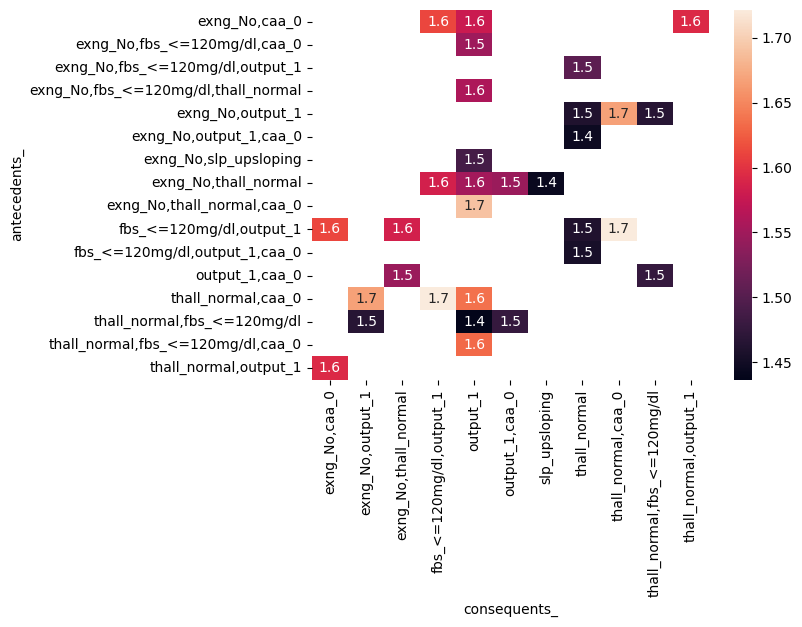

In [25]:
#Plotting a correlation matrix for the strong association rules where the number of items on the left hand side is greater than 1
MATRIX_STRONG_ASSOCIATION_RULES = STRONG_ASSOCIATION_RULES.copy()
MATRIX_STRONG_ASSOCIATION_RULES = MATRIX_STRONG_ASSOCIATION_RULES.head(50)
MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "antecedents"
].apply(lambda x: len(x))
#MATRIX_STRONG_ASSOCIATION_RULES[
    #MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] > 1
#].sort_values("lift", ascending=False).head()
MATRIX_STRONG_ASSOCIATION_RULES["antecedents_"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "antecedents"
].apply(lambda a: ",".join(list(a)))
MATRIX_STRONG_ASSOCIATION_RULES["consequents_"] = MATRIX_STRONG_ASSOCIATION_RULES[
    "consequents"
].apply(lambda a: ",".join(list(a)))
pivot = MATRIX_STRONG_ASSOCIATION_RULES[
    MATRIX_STRONG_ASSOCIATION_RULES["antecedents_len"] > 1
].pivot(index="antecedents_", columns="consequents_", values="lift")
sns.heatmap(pivot, annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [26]:
MATRIX_STRONG_ASSOCIATION_RULES

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_len,antecedents_,consequents_
0,"(fbs_<=120mg/dl, output_1)","(thall_normal, caa_0)",0.468647,0.392739,0.316832,0.676056,1.721387,1.0,0.132776,1.874587,0.788690,0.581818,0.466549,0.741390,2,"fbs_<=120mg/dl,output_1","thall_normal,caa_0"
1,"(thall_normal, caa_0)","(fbs_<=120mg/dl, output_1)",0.392739,0.468647,0.316832,0.806723,1.721387,1.0,0.132776,2.749175,0.690104,0.581818,0.636255,0.741390,2,"thall_normal,caa_0","fbs_<=120mg/dl,output_1"
2,(output_1),"(exng_No, thall_normal, caa_0)",0.544554,0.333333,0.306931,0.563636,1.690909,1.0,0.125413,1.527778,0.897148,0.537572,0.345455,0.742214,1,output_1,"exng_No,thall_normal,caa_0"
3,"(exng_No, thall_normal, caa_0)",(output_1),0.333333,0.544554,0.306931,0.920792,1.690909,1.0,0.125413,5.750000,0.612903,0.537572,0.826087,0.742214,3,"exng_No,thall_normal,caa_0",output_1
4,"(exng_No, output_1)","(thall_normal, caa_0)",0.468647,0.392739,0.306931,0.654930,1.667594,1.0,0.122875,1.759817,0.753423,0.553571,0.431759,0.718221,2,"exng_No,output_1","thall_normal,caa_0"
5,"(thall_normal, caa_0)","(exng_No, output_1)",0.392739,0.468647,0.306931,0.781513,1.667594,1.0,0.122875,2.431962,0.659245,0.553571,0.588809,0.718221,2,"thall_normal,caa_0","exng_No,output_1"
6,(output_1),"(thall_normal, caa_0)",0.544554,0.392739,0.349835,0.642424,1.635752,1.0,0.135967,1.698272,0.853363,0.595506,0.411166,0.766590,1,output_1,"thall_normal,caa_0"
7,"(thall_normal, caa_0)",(output_1),0.392739,0.544554,0.349835,0.890756,1.635752,1.0,0.135967,4.169078,0.640023,0.595506,0.760139,0.766590,2,"thall_normal,caa_0",output_1
8,"(thall_normal, fbs_<=120mg/dl, caa_0)",(output_1),0.356436,0.544554,0.316832,0.888889,1.632323,1.0,0.122733,4.099010,0.601923,0.542373,0.756039,0.735354,3,"thall_normal,fbs_<=120mg/dl,caa_0",output_1
9,(output_1),"(thall_normal, fbs_<=120mg/dl, caa_0)",0.544554,0.356436,0.316832,0.581818,1.632323,1.0,0.122733,1.538958,0.850543,0.542373,0.350210,0.735354,1,output_1,"thall_normal,fbs_<=120mg/dl,caa_0"


In [27]:


antecedents = STRONG_ASSOCIATION_RULES['antecedents'].apply(lambda x: ', '.join(list(x))).tolist()
consequents = STRONG_ASSOCIATION_RULES['consequents'].apply(lambda x: ', '.join(list(x))).tolist()
lifts = STRONG_ASSOCIATION_RULES['lift']

nodes = list(set(antecedents + consequents))
node_indicies = {node: i for i, node in enumerate(nodes)}

links = []
for ancentent, consequent, lift in zip(antecedents, consequents, lifts):
    links.append({
        'source': node_indicies[ancentent],
        'target': node_indicies[consequent],
        'value': lift
    })

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = nodes
    ),
    link = dict(
      source = [link['source'] for link in links],
      target = [link['target'] for link in links],
      value = [link['value'] for link in links],
      color = 'blue',
    ))])
fig.update_layout(title_text="Sankey Diagram for Association Rules", font_size=10)
fig.show()

### Graph of the top 50 strong association rules

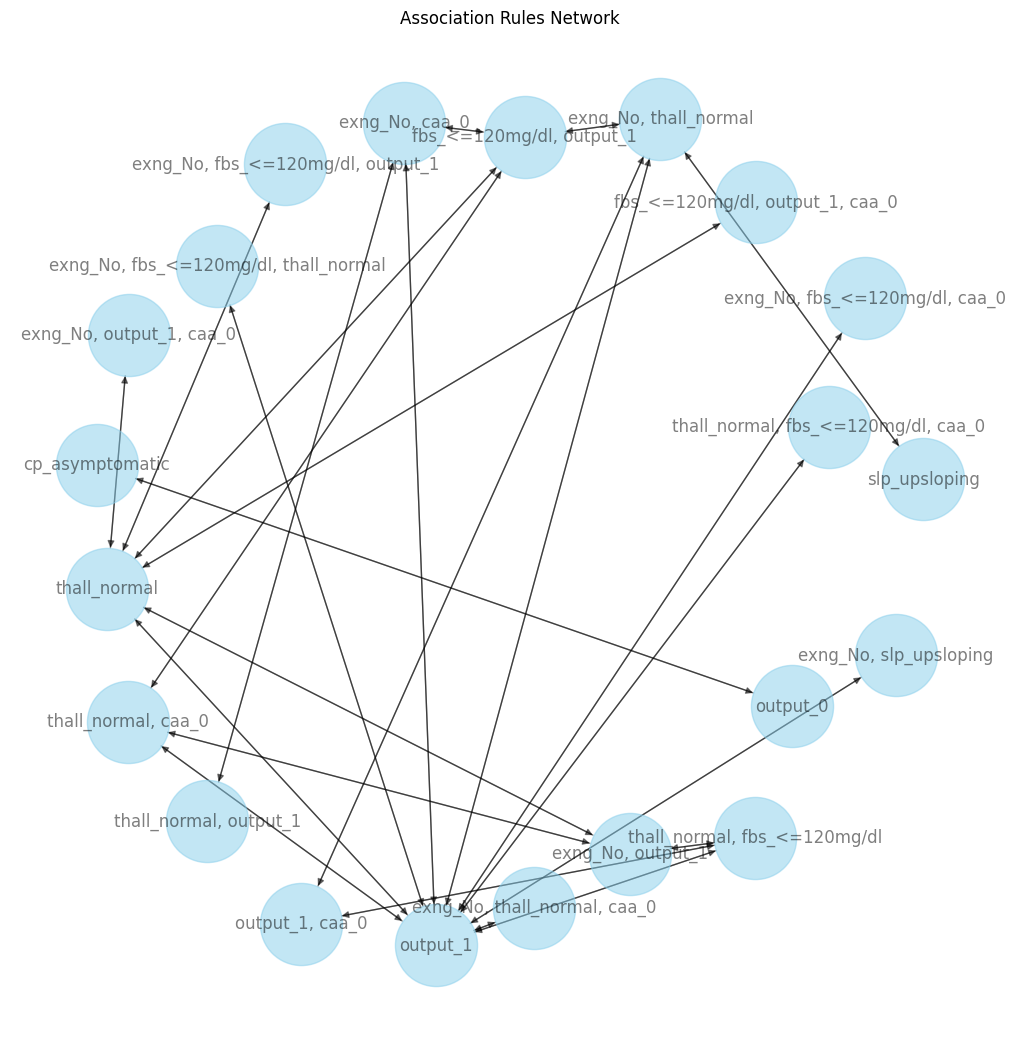

In [28]:
GRAPH_STRONG_ASSOCIATON_RULES = STRONG_ASSOCIATION_RULES.copy().head(50)
GRAPH_STRONG_ASSOCIATON_RULES["antecedents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "antecedents"
].apply(lambda x: ", ".join(list(x)))
GRAPH_STRONG_ASSOCIATON_RULES["consequents"] = GRAPH_STRONG_ASSOCIATON_RULES[
    "consequents"
].apply(lambda x: ", ".join(list(x)))

G = nx.from_pandas_edgelist(
    GRAPH_STRONG_ASSOCIATON_RULES,
    source="antecedents",
    target="consequents",
    edge_attr=True,
    create_using=nx.DiGraph(),
)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=4, seed=1)
nx.draw(G, with_labels=True, node_size=3500, node_color="skyblue", node_shape="o", alpha=0.5, pos=pos, arrows=True)
plt.title("Association Rules Network")
plt.show()

### Scatter plot metrics from ARM

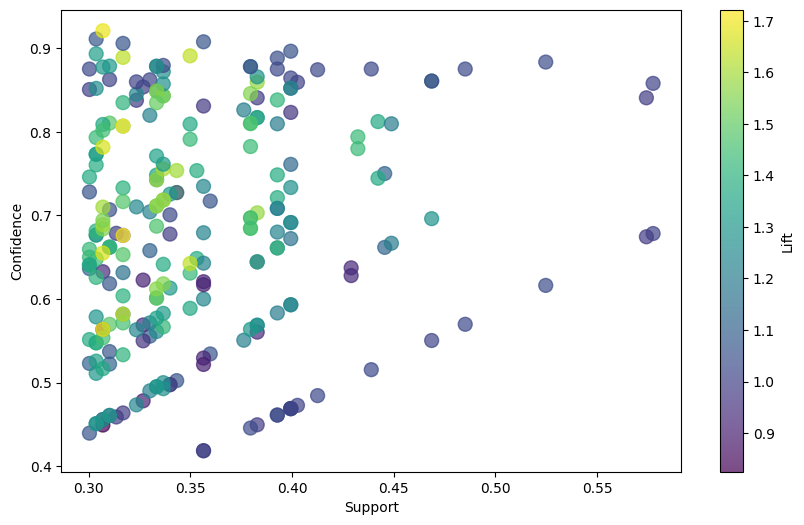

In [29]:
# Create the scatter plot of association rules
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    ASSOCIATION_RULES["support"],
    ASSOCIATION_RULES["confidence"],
    c=ASSOCIATION_RULES["lift"],
    cmap="viridis",
    s=100,
    alpha=0.7,
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.colorbar(scatter, label="Lift")

We can observe that the associatoon rules with a high lift have a relatively low support. 

# Data preprocessing

In [30]:
# Target column and feature set
y = HEART_DATA[TARGET_COLUMN]
X = HEART_DATA.drop(TARGET_COLUMN, axis = 1)

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Normalize and encode 

In [31]:
#Normalize the numerical data 
NUM_TRANSFORMER = Pipeline(steps=[('scaler', StandardScaler())])

#For linear models, it is necessary to encode the categorical data to avoid introducing unintented relationships and biased.  
CAT_TRANSFORMER = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

#Define a pre processer
PRE_PROCESSOR = ColumnTransformer(transformers=[
    ('num', NUM_TRANSFORMER, NUMERICAL_COLS),
    ('cat', CAT_TRANSFORMER, CATEGORICAL_COLS)
])

### PCA - reduce data dimensions 

In [ ]:
# Find best parameters for PCA
PCA_PIPELINE = Pipeline(
    steps=[
        ("preprocessor", PRE_PROCESSOR),
        ("pca", PCA()),
        ("model", LinearRegression()),
    ]
)
PCA_PARAM_GRID = {
    "pca__n_components": range(1, PRE_PROCESSOR.fit_transform(X_train).shape[1] + 1)
}

PCA_GRID_SEARCH = GridSearchCV(
    estimator=PCA_PIPELINE,
    param_grid=PCA_PARAM_GRID,
    scoring="neg_mean_squared_error",
    cv=5,
)

PCA_GRID_SEARCH.fit(X_train, np.log1p(y_train))
# Obtain the best number of parameters for PCA
BEST_PARAM_PCA_SEARCH = PCA_GRID_SEARCH.best_params_
BEST_SCORE_PCA_SEARCH = PCA_GRID_SEARCH.best_score_

print(f"Best parameters for PCA: {BEST_PARAM_PCA_SEARCH}")
print(f"Best score for PCA: {BEST_SCORE_PCA_SEARCH}")

BEST_PARAM_PCA = {}
for key, value in BEST_PARAM_PCA_SEARCH.items():
    BEST_PARAM_PCA[key.split("__")[1]] = value

BEST_PARAM_PCA
PCA_BEST = PCA(n_components=BEST_PARAM_PCA["n_components"])

PRE_PROCESSOR_PCA_BEST = Pipeline(
    steps=[("preprocessor", PRE_PROCESSOR), ("pca", PCA_BEST)]
)
PCA_2 = PCA(n_components=2)
PRE_PROCESSOR_PCA_2 = Pipeline(steps=[("preprocessor", PRE_PROCESSOR), ("pca", PCA_2)])

Best parameters for PCA: {'pca__n_components': 12}
Best score for PCA: -0.06005714174691057


# Clustering analysis

Before clustering I will scatter plot the data to see if there is possible to observe any clusters in the data (train and test together)

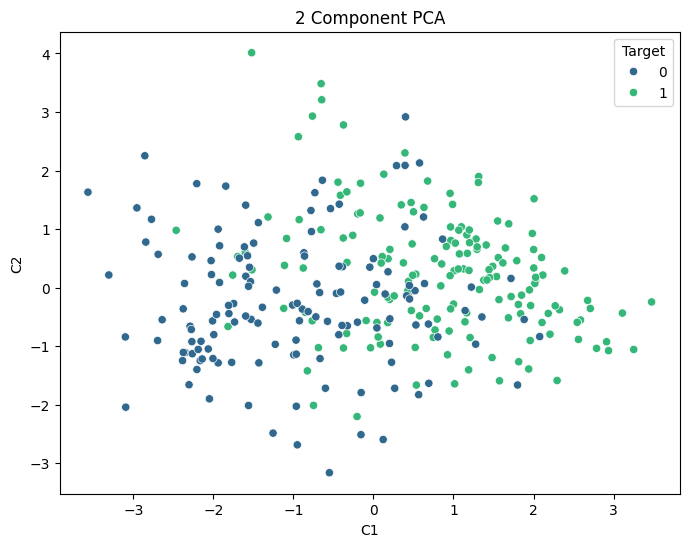

In [33]:
pca_2 = PCA(n_components=2)
X_pca = PRE_PROCESSOR_PCA_2.fit_transform(X)

DF_PCA_2 = pd.DataFrame(X_pca, columns=["C1", "C2"])
DF_PCA_2["Target"] = y
plt.figure(figsize=(8, 6))
sns.scatterplot(DF_PCA_2, x='C1', y='C2', hue='Target', palette='viridis')
plt.title('2 Component PCA')
plt.show()


The color represents the Target variable, and the points do not form clearly separated clusters. Instead, there is a large overlapping central region with a few outliers scattered farther away. This suggests the data may lack strong inherent clusters. Clustering methods like K-Means or Agglomerative Clustering may struggle to form meaningful clusters due to the lack of clear boundaries. However, density-based methods like DBSCAN might still be useful for identifying outliers or small, dense subgroups.

### Some helping functions

In [34]:
#Some helping functions for the clustering analysis 
#Finding the optimal k for K-means
def find_optimal_k(X_scaled : np.array) -> tuple[int, float]:
    k_values = range(2,11)
    silhouette_scores = {}
    inertia_values = []
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores[k] = score
        inertia_values.append(kmeans.inertia_)
        
    optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    optimal_score = silhouette_scores[optimal_k]
    print(f"Optimal number of clusters: {optimal_k}")
    print (f"Optimal silhouette score: {optimal_score}")
    return optimal_k, optimal_score

def find_k_plot(silhouette_scores : dict[int, float], inertia_values : list[float]) -> None:
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.plot(silhouette_scores.keys(), silhouette_scores.values(), marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of clusters')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(2,11), inertia_values, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia vs Number of clusters')
    plt.grid(True)

def find_optimal_eps(X_scaled : np.array, eps_range, min_samples_range) -> tuple[float, float]:
    best_score = -1
    best_params = None
    results = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(X_scaled)
            
            #Skip cases with 1 cluster 
            if len(set(cluster_labels)) > 1:
                score = silhouette_score(X_scaled, cluster_labels)
                results.append({'eps': eps, 'min_samples': min_samples, 'silhouette_score': score})
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
    sorted_results = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
    return best_params, best_score, sorted_results


We might want to reduce the dimensionality to 2 for better visualization of the clustering. 
To do this I will perform clustering on two different arrays, one array is obtain from using PCA with n_components=2, and one array is obtained from using PCA with n_components = 12 (which is the best parameter we found) and then perform t-SNE to reduce the dimensionality to 2. We will then look for differences in the silohuette score. 

In [35]:
#PCA-only (2D)
pca_n_2 = PCA(n_components=2)
X_train_pca_2 = pca_n_2.fit_transform(X_train)
X_test_pca_2 = pca_n_2.transform(X_test)

#PCA + t-SNE (4D to 2D)
X_train_pca = PRE_PROCESSOR_PCA_BEST.fit_transform(X_train)
tsne_2 = TSNE(n_components=2, random_state=42)
X_train_pca_tsne = tsne_2.fit_transform(X_train_pca)

optimal_k_pca_2, optimal_score_pca_2 = find_optimal_k(X_train_pca_2)
optimal_k_pca_tsne, optimal_score_pca_tsne = find_optimal_k(X_train_pca_tsne)

Optimal number of clusters: 2
Optimal silhouette score: 0.45947953484917686
Optimal number of clusters: 2
Optimal silhouette score: 0.44480279088020325


We can see that the optimal k is 2 for both but that the silhouette score is slighly better when we only use PCA. I will therefore continue using the array where pca were performed. 


In [36]:
OPTIMAL_K, OPTIMAL_SCORE = find_optimal_k(X_train_pca_2)
EPS_RANGE = np.linspace(0.1, 1.0, 10)
min_samples_range = range(2, 11)
DBSCAN_BEST_PARAMS, DBSCAN_BEST_SCORE, DBSCAN_SORTED_RESULTS = find_optimal_eps(X_train_pca_2, EPS_RANGE, min_samples_range)
DBSCAN_BEST_PARAMS

Optimal number of clusters: 2
Optimal silhouette score: 0.45947953484917686


{'eps': 0.1, 'min_samples': 2}

In [37]:
# Finding the best clustering method
CLUSTERING_METHODS = [
    {"model": DBSCAN,
     "name": "DBSCAN",
     "params": DBSCAN_BEST_PARAMS},
    {"model": AgglomerativeClustering,
     "name": "Agglomerative Clustering",
     "params": {
         'n_clusters': 3
     }},
    {"model": KMeans,
     "name": "KMeans",
     "params": {
         'n_clusters': optimal_k_pca_2
     }},
    ]
for method in CLUSTERING_METHODS:
    model = method["model"](**method["params"])
    cluster_labels = model.fit_predict(X_train_pca_2)
    if len(set(cluster_labels)) > 1:  # Ensure there is more than one cluster
        silhouette = silhouette_score(X_train_pca_2, cluster_labels)
        print(f"{method['name']} silhouette score: {silhouette}")
    else:
        print(f"{method['name']} did not produce more than one cluster.")

DBSCAN silhouette score: 0.111682565966266
Agglomerative Clustering silhouette score: 0.3173751296558351
KMeans silhouette score: 0.45947953484917686


KMeans are giving the best silhouette score, so we will continue to use this method for the clustering. 

In [38]:
kmeans_2D = KMeans(n_clusters=OPTIMAL_K, random_state=42)
cluster_labels_2D = kmeans_2D.fit_predict(X_train_pca_2)

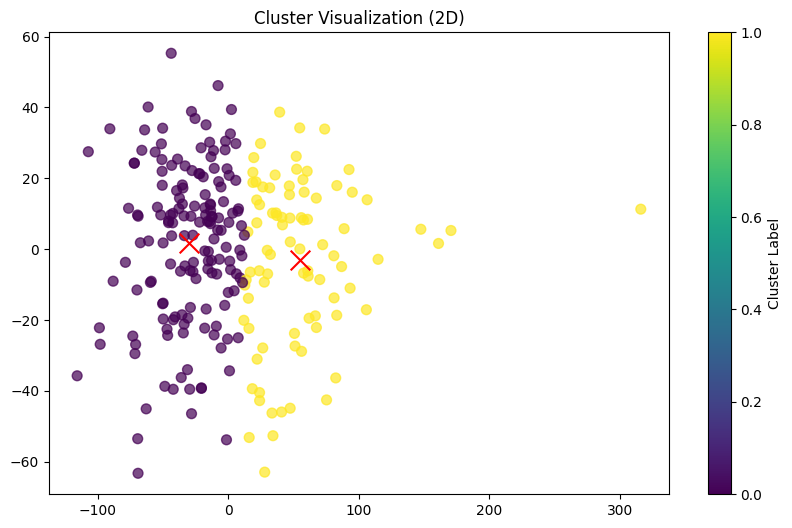

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=cluster_labels_2D, cmap='viridis', s=50, alpha=0.7, marker = 'o')
plt.scatter(kmeans_2D.cluster_centers_[:, 0], kmeans_2D.cluster_centers_[:, 1], s=200, c='red', marker='x')
plt.title('Cluster Visualization (2D)')
plt.colorbar(label='Cluster Label')

The K-Means clustering with two clusters divides the data into two regions centered around the red centroids, creating a simple boundary near the middle of the points. The clusters are somewhat symmetrical but show significant overlap, suggesting that the data lacks a clear, natural separation into two distinct groups. This forced division likely reflects a gradient in the data rather than meaningful clusters, limiting its informational value. The centroids are positioned near the densest regions, but the overall clustering does not capture strongly separated structures, indicating that K-Means may not be the optimal method for this dataset.

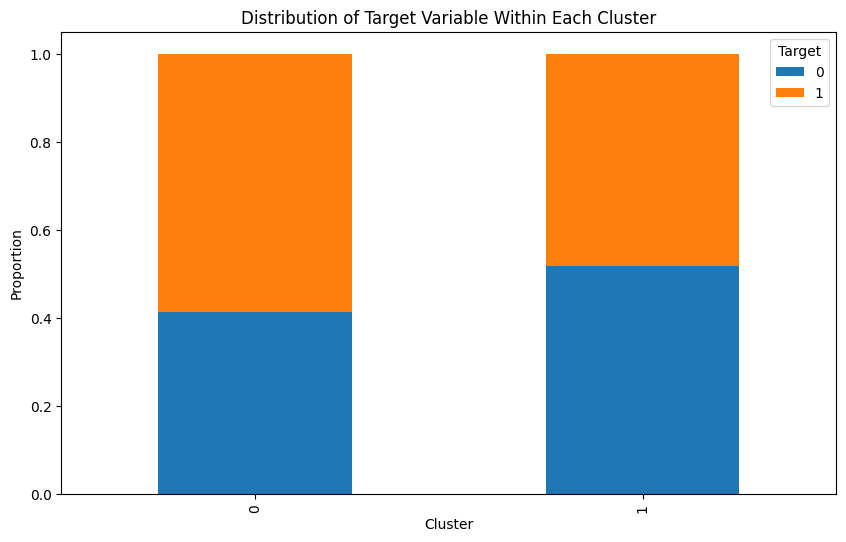

In [40]:
cluster_analysis_df = pd.DataFrame({
    "Cluster": cluster_labels_2D,
    "Target": y_train
})
cluster_distribution = cluster_analysis_df.groupby("Cluster")["Target"].value_counts(normalize=True).unstack()
cluster_distribution.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Distribution of Target Variable Within Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="Target", loc="upper right")
plt.show()

Make a dataframe with the cluster labels from Kmeans, and the PCA components. 
We can try to use this to predict the target variable and compare to the predictions done with other datasets

In [41]:
X_train_kmeans = X_train.copy()
X_train_kmeans['kmeans_label'] = kmeans_2D.fit_predict(X_train_pca_2)
X_test_kmeans = X_test.copy()
X_test_kmeans['kmeans_label'] = kmeans_2D.predict(X_test_pca_2)

Density-based clustering (e.g., DBSCAN) might still be useful for identifying outliers or smaller subgroups. But DBSCAN is not typically suited for clustering as a preprocessing step for classification.  Instead, it excels in other specific scenarios like outlier detection and identifying densely packed subgroups So the DBScan will only be performed for visualization and insights and will not be used in any further classification

Number of clusters found (excluding noise): 17
Unique labels (including noise if present): [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


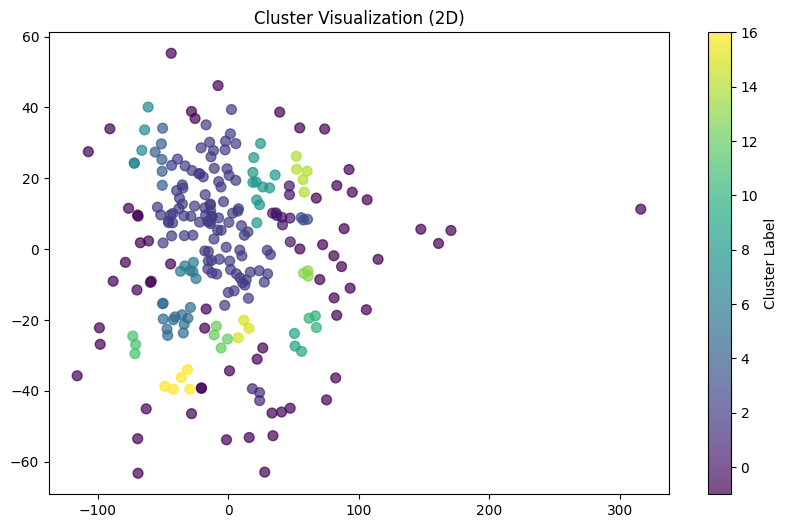

In [42]:
dbscan = DBSCAN(eps=7, min_samples=3)
cluster_labels_dbscan = dbscan.fit_predict(X_train_pca_2)
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=cluster_labels_dbscan, cmap='viridis', s=50, alpha=0.7, marker = 'o')
plt.title('Cluster Visualization (2D)')
plt.colorbar(label='Cluster Label')
unique_clusters = np.unique(cluster_labels_dbscan)
n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
print(f"Number of clusters found (excluding noise): {n_clusters}")
print(f"Unique labels (including noise if present): {unique_clusters}")


# Classification analysis

In [44]:
#Fit and transform training data
X_train = PRE_PROCESSOR.fit_transform(X_train)
X_test  = PRE_PROCESSOR.transform(X_test)

In [ ]:
#Helping functions 


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    return acc_train, acc_test, y_test_pred

def plot_confusion_matrix(y_true, y_pred, target_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, cmap='coolwarm', fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
def train_and_validate_model(data : pd.DataFrame, target_column : str, pre_processor : Optional[Pipeline]):
    

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
#Set up classifiers and parameter grid 
CLASSIFIERS_AND_PARAM_GRIDS =  [
    {"name" : "Logistic Regression",
        "model": LogisticRegression,
     "param_grid": {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
         
     }},
    
    {"name" : 'SVC',
     "model": SVC,
     "params_grid" : {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
            'degree': [2, 3, 4]
     }
    }, 
    
    {"name" : "Random Forest",
    "model": RandomForestClassifier,
     "params_grid" : {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'max_features': ['sqrt', 'log2']
     }
     
    }, 
    { "name" : 'Decision Tree',
       "model": DecisionTreeClassifier,
       "params_grid" : {
            'max_depth': [5, 10, 15],
            'max_features': ['sqrt', 'log2']
           },
    },
    
    {"name" : 'Gradient Boosting',
     "model": GradientBoostingClassifier,
     "params_grid" : { 
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'max_features': ['sqrt', 'log2']
     }
    },
    {"name" : 'XGBoost',
     "model": XGBClassifier,
     "params_grid" : {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1, 0.3]
     }
    },
    {"name" : 'LightGBM',
     "model": LGBMClassifier,
     "params_grid" : {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1, 0.3]
     }
    },
    {"name" : 'CatBoost',
     "model": CatBoostClassifier,
     "params_grid" : {
            'iterations': [100, 200, 300],
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15],
            'learning_rate': [0.01, 0.1, 0.3]
            
     }
    },
    {"name" : 'AdaBoost',
     "model": AdaBoostClassifier,
     "params_grid" : {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3]
     }
    },
    {"name" : 'KNN',
     "model": KNeighborsClassifier,
     "params_grid" : {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
     }
    },
    {"name" : 'MLP',
     "model": MLPClassifier,
     "params_grid" : {
            'hidden_layer_sizes': [(50, 50), (100, 100), (200, 200)],
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': [0.0001, 0.001, 0.01]
     }
    },
    {"name" : 'Naive Bayes',
     "model": GaussianNB,
     "params_grid" : {}
    }
]

#Use grid search and cross valication for hyperparamter tuning

In [ ]:
#Train and evaluate the model on different datasets, e.g. original data, PCA, clustering labels

#Save the scores in a disctionary to be able to plot the scores of each model
#Compare the models by using different accuracy metrics e.g R2
#Plot the confusion matrixes for each of the models 
#Compare the accuracy in the train and test set